In [53]:
# Imports
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from statsmodels.tsa.vector_ar.var_model import VAR
import seaborn as sns
from matplotlib import pyplot as plt

In [13]:
# Define your path
path = "/Users/joche/Documents/GitHub/GVAR_modeling/"

# Data preperation

In [74]:
# Import all data for different variables
variable_list_raw = ['GDP', 'CPI','long_int','short_int','exch_rate','CPI_lag']
df_variable_raw = pd.read_excel(path + "Variable_data.xlsx",index_col=0, sheet_name=variable_list_raw)
df_variable = {}

# Transformating the data
df_variable['GDP'] = np.log(df_variable_raw['GDP'] / df_variable_raw['CPI'])
df_variable['inf_rate'] = np.log(df_variable_raw['CPI']) - np.log(df_variable_raw['CPI_lag'])
df_variable['long_int'] = 1/12 * np.log(1+ df_variable_raw['long_int'])
df_variable['short_int'] = 1/12 * np.log(1+ df_variable_raw['short_int'])
df_variable['exch_rate'] = np.log(df_variable_raw['exch_rate']) - np.log(df_variable_raw['CPI'])
variable_list = ['GDP', 'inf_rate','long_int','short_int','exch_rate']
ext_variable_list = ['Real gross domestic product','Inflation rate','Long-term interest rate','Short-term interest rate','Real exchange rate']

In [75]:
# Example of the data of GDP
df_variable['GDP']

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP,,,,,,,,,,,,,,,,,,,,,
Australia,7.109036,7.109974,7.110185,7.109530,7.108802,7.108989,7.110926,7.113886,7.117019,7.119468,...,7.256221,7.253441,7.240865,7.227896,7.224177,7.229641,7.235047,7.231188,7.215890,7.193299
Brazil,7.272674,7.265720,7.265417,7.256463,7.248838,7.244975,7.247261,7.258204,7.265983,7.258871,...,6.285674,6.278033,6.235718,6.189132,6.196739,6.242242,6.286123,6.282903,6.232938,6.146120
Canada,7.179651,7.181538,7.179857,7.180545,7.179913,7.182289,7.184030,7.185522,7.186714,7.188435,...,7.249929,7.247701,7.237002,7.232758,7.232666,7.236233,7.235607,7.228977,7.228794,7.236300
France,7.376893,7.374008,7.368666,7.368401,7.367229,7.369247,7.371672,7.374122,7.372320,7.371964,...,7.392095,7.390753,7.383974,7.375243,7.371668,7.367607,7.374306,7.364905,7.362244,7.363409
Germany,7.689264,7.687997,7.692860,7.697680,7.700746,7.702350,7.701614,7.700564,7.700468,7.703739,...,7.620413,7.613663,7.607345,7.610771,7.607649,7.602990,7.582952,7.574108,7.571647,7.575879
Italy,7.392979,7.388844,7.384859,7.380755,7.376688,7.374707,7.375641,7.374702,7.373541,7.371942,...,7.044398,7.049587,7.044755,7.035293,7.031500,7.023092,7.019768,6.986019,6.981736,6.980505
Japan,12.857878,12.864728,12.867386,12.865950,12.867956,12.873344,12.873884,12.872888,12.868379,12.871025,...,12.963230,12.964119,12.961798,12.960275,12.953797,12.949108,12.945054,12.939715,12.938600,12.937705
Korea,13.776915,13.780017,13.780195,13.780365,13.781326,13.787516,13.788214,13.788435,13.791600,13.797770,...,14.098437,14.093655,14.090882,14.088052,14.084168,14.083898,14.078846,14.074884,14.075795,14.074829
New Zealand,5.006075,5.009471,5.012160,5.013734,5.014867,5.016341,5.018788,5.021249,5.022145,5.020725,...,5.230203,5.231278,5.205242,5.178263,5.177766,5.203146,5.226279,5.221344,5.181424,5.117220


In [76]:
# Get all countries in a list
country_list = df_variable['GDP'].index.values

# Define an empty dataframe
df = {}

# Loop over all countries and put their variable data in dataframe df
for country in country_list:
    country_collection = []
    
    for variable in variable_list:
        country_collection.append(df_variable[variable].loc[country])
    
    df[country] = pd.DataFrame(country_collection,index=variable_list)

In [77]:
# Example of the data of the United States
df['United States']

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP,9.446327,9.449027,9.449879,9.451822,9.455296,9.458997,9.459453,9.458641,9.457156,9.458032,...,9.439476,9.433604,9.423242,9.411141,9.413816,9.417373,9.418303,9.416653,9.419140,9.423118
inf_rate,0.005949,0.003243,0.005055,0.003914,0.001951,0.000557,0.001946,0.001943,0.003183,0.003173,...,0.013285,0.005597,0.010951,0.013633,-0.000147,-0.000368,0.002206,0.004032,-0.001025,-0.003081
long_int,0.010751,0.010992,0.011676,0.012210,0.012748,0.012210,0.011929,0.012239,0.011951,0.012225,...,0.008018,0.008026,0.008185,0.008652,0.009011,0.008637,0.008884,0.009168,0.008907,0.008981
short_int,0.004375,0.004185,0.004296,0.004351,0.004351,0.004430,0.004485,0.004383,0.004470,0.004391,...,0.000606,0.000755,0.001101,0.001544,0.002058,0.002269,0.002633,0.003148,0.003636,0.003676
exch_rate,-4.260000,-4.263243,-4.268298,-4.272212,-4.274163,-4.274720,-4.276666,-4.278609,-4.281792,-4.284965,...,-4.881665,-4.887262,-4.898213,-4.911846,-4.911699,-4.911330,-4.913537,-4.917569,-4.916544,-4.913463


# Trade matrix

In [78]:
# Import all trading data
df_trade_raw = pd.read_excel(path + "Trade_statistics.xlsx",index_col=[0,1])

# Get a list of all years (data from 1994 until 2022)
year_list = df_trade_raw.columns

# Define an empty dataframe
df_trade_year = {} 

# Loop over all years and put the trade weights data of that year in dataframe df_trade_year
for year in year_list:
    country_collection = []
    
    for country in country_list:
        country_collection.append(df_trade_raw.loc[country, year] / np.sum(df_trade_raw.loc[country, year]))
    
    df_trade_year[year] = pd.DataFrame(country_collection,index=country_list)

In [79]:
# Example of the trade weights on the year 2000
df_trade_year[2000]

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.009499,0.024256,0.015715,0.022248,0.031067,0.368421,0.139010,0.109102,0.021377,0.012284,0.063816,0.183204
Brazil,0.012822,0.000000,0.021274,0.065131,0.095000,0.080711,0.092992,0.021844,0.001296,0.011364,0.037926,0.056359,0.503281
Canada,0.003000,0.002689,0.000000,0.004871,0.007887,0.004335,0.022968,0.005707,0.000482,0.000620,0.001581,0.014831,0.931028
France,0.006890,0.014365,0.014387,0.000000,0.277243,0.155041,0.027482,0.013763,0.001199,0.006146,0.160982,0.169509,0.152993
Germany,0.011850,0.017602,0.015107,0.236602,0.000000,0.158056,0.046231,0.015814,0.001668,0.013074,0.093985,0.173398,0.216612
Italy,0.013134,0.016574,0.015812,0.224279,0.267343,0.000000,0.029327,0.012335,0.001646,0.006712,0.111315,0.121739,0.179782
Japan,0.034618,0.010164,0.030154,0.030228,0.080685,0.023379,0.000000,0.123875,0.005102,0.007577,0.013335,0.059860,0.581023
Korea,0.031966,0.021146,0.029763,0.021458,0.063209,0.023418,0.251006,0.000000,0.003509,0.006069,0.018803,0.065981,0.463673
New Zealand,0.302224,0.003885,0.022302,0.022475,0.034591,0.025347,0.205571,0.065756,0.000000,0.005530,0.008444,0.082456,0.221417
South Africa,0.042235,0.017777,0.019369,0.047268,0.167820,0.074288,0.119648,0.052628,0.002717,0.000000,0.043997,0.199527,0.212726


In [80]:
# Define the normal trade weight (which is an average of the last three years)
df_trade = (df_trade_year[1993] + df_trade_year[1994] + df_trade_year[1995])/3

# Potentially save this trade matrix
# df_trade.to_excel(path + "saved_values.xlsx")

# Show the chosen trade matrix
df_trade

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.008695,0.031125,0.020313,0.027501,0.029473,0.422486,0.132150,0.115496,0.012373,0.007620,0.067694,0.125073
Brazil,0.012786,0.000000,0.024467,0.046825,0.103713,0.080085,0.136933,0.034136,0.001838,0.011543,0.039634,0.063569,0.444472
Canada,0.004381,0.004788,0.000000,0.006822,0.012462,0.006200,0.048321,0.010508,0.000680,0.000768,0.001999,0.015696,0.887375
France,0.007999,0.007755,0.012718,0.000000,0.317674,0.173072,0.035865,0.012381,0.001229,0.006044,0.129186,0.174254,0.121825
Germany,0.015579,0.018173,0.013884,0.262833,0.000000,0.165993,0.058338,0.024076,0.002175,0.016558,0.073423,0.176180,0.172786
Italy,0.011154,0.017354,0.015598,0.230207,0.336073,0.000000,0.037012,0.015691,0.001984,0.007676,0.082110,0.112037,0.133103
Japan,0.040304,0.009912,0.029764,0.027565,0.092120,0.017409,0.000000,0.121341,0.007258,0.010393,0.010995,0.063685,0.569254
Korea,0.027392,0.018277,0.031319,0.023447,0.093984,0.016194,0.287797,0.000000,0.003286,0.007146,0.013616,0.042586,0.434957
New Zealand,0.313003,0.005407,0.025821,0.017027,0.037556,0.020387,0.237031,0.075653,0.000000,0.003830,0.006465,0.091912,0.165908
South Africa,0.029227,0.024074,0.012801,0.063221,0.153470,0.093988,0.105488,0.054068,0.002478,0.000000,0.046956,0.234887,0.179344


# VARX model

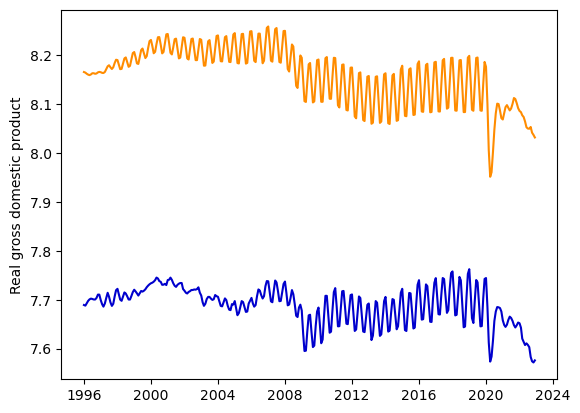

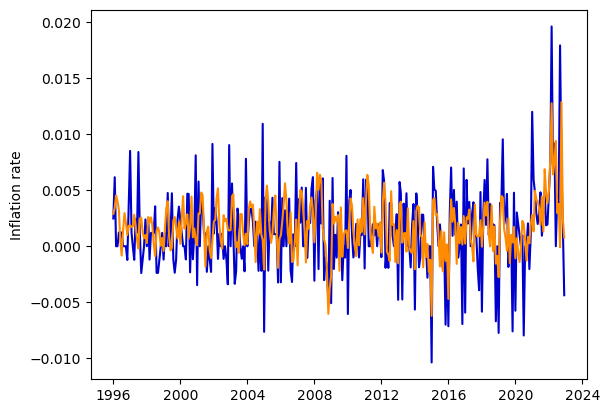

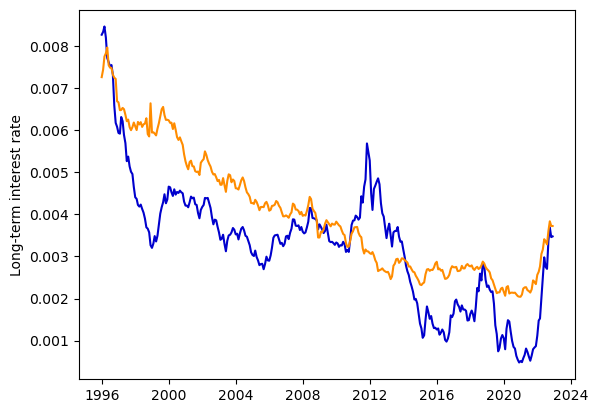

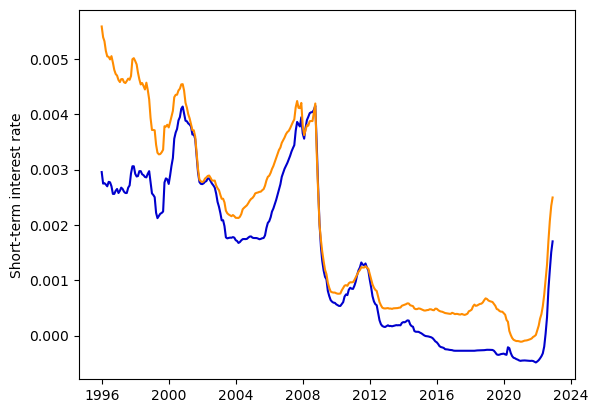

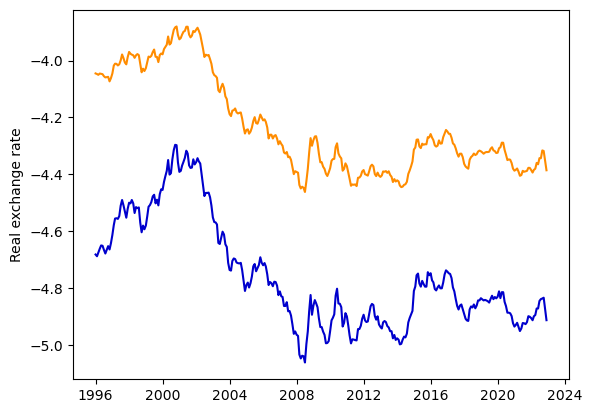

In [101]:
# Define the country
country = 'Germany'

# Define the x_it and x_star for a country
x_it = df[country].T
x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)

# Plot x_it and x_star for every variable
for i in range(len(variable_list)):
    sns.lineplot(x_it[variable_list[i]],c='mediumblue')
    sns.lineplot(x_star[variable_list[i]],c='darkorange')
    plt.ylabel(ext_variable_list[i])
    plt.show()

In [41]:
# Define a dataframe (dictionary) for the parameter estimates and the R_squared
df_estimates = {}
df_Rsquared = pd.DataFrame(index=variable_list)

# Loop over all countries
for country in country_list:

    # Define matrix x_it
    x_it = df[country].T
    x_it.columns = x_it.columns + "_x_it"
    
    # Define matrix x_star
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.columns = x_star.columns + "_x_star"

    # Combine x_it and x_star and define the period frequency
    df_country = pd.concat([x_it,x_star], axis=1)
    df_country.index.freq = 'MS'

    # Create a VAR model object
    model = VAR(df_country)

    # Fit the VAR model with a constant and trend
    results = model.fit(maxlags=2,trend='ct')

    # Fill the parameter estimates of the VARX model in the dictionary
    df_estimates[country] = results.params[x_it.columns.tolist()].T

    # Calculate all R^2's of all variables
    for variable in variable_list:
        df_Rsquared.loc[variable,country] = skm.r2_score(results.fittedvalues[variable+"_x_it"]+results.resid[variable+"_x_it"],results.fittedvalues[variable+"_x_it"])

In [42]:
# Example of the VARX estimates of Australia
df_estimates['France']

,const,trend,L1.GDP_x_it,L1.int_rate_x_it,L1.long_int_x_it,L1.short_int_x_it,L1.exch_rate_x_it,L1.GDP_x_star,L1.int_rate_x_star,L1.long_int_x_star,...,L2.GDP_x_it,L2.int_rate_x_it,L2.long_int_x_it,L2.short_int_x_it,L2.exch_rate_x_it,L2.GDP_x_star,L2.int_rate_x_star,L2.long_int_x_star,L2.short_int_x_star,L2.exch_rate_x_star
GDP_x_it,3.323965,2.590100e-05,0.186398,0.894689,-6.845780,-0.837186,0.137202,1.409787,0.967177,-1.497822,...,-0.439394,0.993787,3.805802,27.511753,0.080192,-0.655539,-0.063944,-4.264560,-40.576235,-0.006645
int_rate_x_it,-0.072671,1.019478e-05,0.087315,-0.276143,2.955067,0.586946,0.074339,-0.150595,0.299551,0.906108,...,-0.080709,-0.179215,-2.271900,-0.710312,-0.080930,0.154584,0.281588,-1.085029,1.122475,0.089548
long_int_x_it,0.001303,-6.538628e-07,-0.000389,0.004177,1.211578,-0.093836,0.001160,0.000667,0.008244,-0.027964,...,0.000789,0.006521,-0.258649,0.103262,-0.001046,-0.001171,-0.004919,0.028334,-0.101178,0.001213
short_int_x_it,-0.003474,1.464914e-07,-0.000636,-0.000778,0.015869,1.312707,0.002144,0.000610,0.001697,0.025819,...,0.000251,0.000804,0.034256,-0.409324,-0.000797,0.000064,0.002994,-0.030716,-0.114078,0.001466
exch_rate_x_it,0.220370,-1.724085e-04,-0.540653,-0.037188,-13.713991,-44.693283,1.150880,0.776444,0.784241,-12.365113,...,0.592922,-0.056203,1.584545,50.234836,-0.167100,-0.867204,0.417142,16.648519,-65.392717,-0.126459


In [43]:
# Example of the VARX estimates of New Zealand
df_estimates['New Zealand']

,const,trend,L1.GDP_x_it,L1.int_rate_x_it,L1.long_int_x_it,L1.short_int_x_it,L1.exch_rate_x_it,L1.GDP_x_star,L1.int_rate_x_star,L1.long_int_x_star,...,L2.GDP_x_it,L2.int_rate_x_it,L2.long_int_x_it,L2.short_int_x_it,L2.exch_rate_x_it,L2.GDP_x_star,L2.int_rate_x_star,L2.long_int_x_star,L2.short_int_x_star,L2.exch_rate_x_star
GDP_x_it,1.838318,-4.817006e-05,1.520973,-1.111301,-4.863738,5.722121,0.018565,-0.013891,0.509064,-7.260204,...,-0.673367,2.718916,0.849567,-6.730228,-0.030468,-0.088264,-0.989684,-1.117702,-3.128741,0.116877
int_rate_x_it,0.014841,4.418728e-06,0.015951,1.358519,0.821942,0.986539,0.004857,-0.012992,0.042713,0.469124,...,-0.008362,-0.814319,-0.821302,-0.634473,-0.001303,0.006743,0.039390,-0.063936,0.444677,0.001263
long_int_x_it,0.008927,-9.677648e-07,0.000034,0.000715,1.124144,0.056670,0.001043,-0.000184,0.007408,0.080680,...,-0.000243,0.005527,-0.187591,-0.074138,-0.000743,-0.000675,0.003383,-0.107691,0.039654,0.001066
short_int_x_it,-0.002950,-9.206630e-07,0.000527,0.005887,0.066931,1.459944,-0.000546,-0.000128,0.003535,0.071272,...,0.000193,-0.001789,-0.033536,-0.512934,0.000192,0.000076,0.005757,-0.101926,-0.219615,0.000724
exch_rate_x_it,-0.915328,-2.505537e-05,0.067253,-1.828584,18.965682,-6.004496,1.007433,-0.084362,-0.404533,-14.158616,...,-0.156037,1.235850,-25.808008,4.052177,-0.061758,0.216597,2.215239,19.258236,30.774876,-0.452845


In [44]:
# The matrix of R^2 values
df_Rsquared

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
GDP,0.964848,0.998739,0.916899,0.907072,0.895313,0.987550,0.958836,0.993095,0.980656,0.994498,0.974127,0.948031,0.918086
int_rate,0.906419,0.482575,0.250538,0.248920,0.149172,0.317280,0.306375,0.403456,0.897176,0.368071,0.444574,0.344927,0.464720
long_int,0.989214,0.990567,0.993490,0.994397,0.985537,0.982836,0.987795,0.989316,0.989884,0.991770,0.984019,0.964403,0.982162
short_int,0.995470,0.956640,0.993373,0.997016,0.996981,0.997597,0.989575,0.990701,0.995658,0.988651,0.997371,0.996641,0.992613
exch_rate,0.993738,0.985533,0.994670,0.987773,0.987744,0.989998,0.966017,0.984292,0.993273,0.961595,0.991808,0.978001,0.999751
